## Statistics for Comparison of Two Data Sets  
### Here: E-OBS and ERA-5

In [1]:
# necessary imports
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import scipy as sc
from sklearn.linear_model import LinearRegression

In [2]:
from scripts.local_paths import eobsPath, era5Path

Load E-OBS and ERA-5 data of Madrid, regridded so that they are comparable. The regridding process can be found as a ``Python`` script in the file ``gridwise_difference_eobs_era5.py`` in the `scripts` package. 

In [3]:
#  --  Madrid  --
ds_tx_madrid_era5 = xr.open_dataset(era5Path("regrid_era5_Madrid.nc"))
ds_tx_madrid_eobs = xr.open_dataset(eobsPath("regrid_eobs_Madrid.nc"))

#  --  Warsaw  --
ds_tx_warsaw_era5 = xr.open_dataset(era5Path("regrid_era5_Warsaw.nc"))
ds_tx_warsaw_eobs = xr.open_dataset(eobsPath("regrid_eobs_Warsaw.nc"))

The two datasets are defined on the same grid, but the longitudes are defined differently in the two sets. We transform the longitude definition of the ERA-5 data from a 0-365 degree scale to a -180-180 degree scale. We also extract the period from the 1st of January 1990 until the 15th of May 2020. 

In [4]:
# transform so that the two datasets are mergeable

# --  Madrid  --
ds_tx_madrid_era5 = ds_tx_madrid_era5.sel(time = slice("1990-01-01", "2020-05-15"))
ds_tx_madrid_era5 = ds_tx_madrid_era5.assign_coords(longitude = (((ds_tx_madrid_era5.longitude + 180) % 360) - 180))

#  --  Warsaw
ds_tx_warsaw_era5 = ds_tx_warsaw_era5.sel(time = slice("1990-01-01", "2020-05-15"))
ds_tx_warsaw_era5 = ds_tx_warsaw_era5.assign_coords(longitude = (((ds_tx_warsaw_era5.longitude + 180) % 360) - 180))

The timestamps of the ERA-5 data is given down to the hour, even though each data point represents a daily maximum. We change the time stamps to only reflect the date, so that it is more easily comparable to the E-OBS data, where the time stamps are already dates. 

In [5]:
#  --  Madrid  --
ds_tx_madrid_era5 = ds_tx_madrid_era5.resample(time = "1D").first()  # .first since we only have one point for each day
ds_tx_madrid_era5 = ds_tx_madrid_era5.rename({"tx" : "tx_era5"})

#  -- Warsaw
ds_tx_warsaw_era5 = ds_tx_warsaw_era5.resample(time = "1D").first()  # .first since we only have one point for each day
ds_tx_warsaw_era5 = ds_tx_warsaw_era5.rename({"tx" : "tx_era5"})

We then perform some basic formatting of the E-OBS data, extracting the desired time period and renaming the ``tx`` variable to reflect the origin data. 

In [6]:
#  --  Madrid  --
ds_tx_madrid_eobs = ds_tx_madrid_eobs.sel(time = slice("1990-01-01", "2020-05-15"))
ds_tx_madrid_eobs = ds_tx_madrid_eobs.rename({"tx" : "tx_eobs"})

#  --  Warsaw  --
ds_tx_warsaw_eobs = ds_tx_warsaw_eobs.sel(time = slice("1990-01-01", "2020-05-15"))
ds_tx_warsaw_eobs = ds_tx_warsaw_eobs.rename({"tx" : "tx_eobs"})

In [7]:
# merge datasets

#  --  Madrid  --
ds_tx_madrid = xr.merge([ds_tx_madrid_era5, ds_tx_madrid_eobs])

#  --  Warsaw  --
ds_tx_warsaw = xr.merge([ds_tx_warsaw_era5, ds_tx_warsaw_eobs])

We now proceed to calculate various statistics for comparison of the two sets of data  

#### R-Squared

There are several ways of obtaining the R-squared value in ``Python``, and we will show three different methods:  
- Manually using the formula for calculating R-squared for two sets of data
- Using the ``corrcoef`` functionality of ``numpy``
- Using the ``LinearRegression`` functionality of ``scikitlearn``

We begin by performing the calculations for Madrid

In [8]:
# pandas dataframe for simple data handling
df_tx_madrid = ds_tx_madrid.to_dataframe()

We begin by calculating $$R^2$$ using the formula  
$$ R^2 = \big(\frac{N\sum xy - (\sum x)(\sum y)}{\sqrt{(N\sum x^2 - (\sum x)^2)(N \sum y^2 - (\sum y)^2)}}\big)^2. $$
We treat the E-OBS data as $x$ and the ERA-5 data as $y$, but we note that this choice is arbitrary. 

In [9]:
# using arithmetics, finding necessary values
df_tx_madrid["tx_eobs_2"] = df_tx_madrid["tx_eobs"]**2
df_tx_madrid["tx_era5_2"] = df_tx_madrid["tx_era5"]**2
df_tx_madrid["tx_eobs_era5"] = df_tx_madrid["tx_eobs"]*df_tx_madrid["tx_era5"]

N = len(df_tx_madrid["tx_eobs"])

r_formula = (N*df_tx_madrid["tx_eobs_era5"].sum() 
             - df_tx_madrid["tx_eobs"].sum()*df_tx_madrid["tx_era5"].sum()
            )/(np.sqrt((N*df_tx_madrid["tx_eobs_2"].sum() - df_tx_madrid["tx_eobs"].sum()**2) 
                       * (N*df_tx_madrid["tx_era5_2"].sum() - df_tx_madrid["tx_era5"].sum()**2)))
r_2_formula = r_formula**2

print("R-squared using formula: ",r_2_formula)

R-squared using formula:  0.9931639340133488


In [10]:
# using numpy corrcoeff
correlation_matrix = np.corrcoef(df_tx_madrid["tx_eobs"], df_tx_madrid["tx_era5"])
r_value= correlation_matrix[0,1]  # correlation coefficient
r_squared = r_value**2

print("\nR-squared using numpy : ", r_squared)


R-squared using numpy :  0.9931639097074129


In the final method, we use the ``LinearRegression`` functionality of ``scikitlearn`` to first perform a linear regression and then use this model to find the R-squared value. 

In [11]:
#   ----   Linear Regression   ----
model = LinearRegression()

# prepare x-values and y-values for regression
x_reg = df_tx_madrid["tx_eobs"].to_numpy().reshape((-1, 1))  # transform to column vector
y_reg = df_tx_madrid["tx_era5"].to_numpy()

model.fit(x_reg, y_reg)

print("intercept: ", model.intercept_)
print("\nslope: ", model.coef_)

# find r-squared using sklearn:
rsq_sklearn = model.score(x_reg, y_reg)
print("\nR-squared using scikitlearn: ", rsq_sklearn)

intercept:  -0.5796604

slope:  [1.0078032]

R-squared using scikitlearn:  0.993163909733952


We will also calculate the Residual Mean Squared Error (RMSE) score for the two sets of data. This is simply found through the formula  
$$ RMSE = \sqrt{\frac{\sum_{n=1}^N (y_n - x_n)^2}{N}}  $$

In [12]:
#   ----   Calculate rmse   ----
r_mse = np.sqrt(((df_tx_madrid["tx_eobs"] - df_tx_madrid["tx_era5"])**2).mean())
print("\n R-MSE: ", r_mse)


 R-MSE:  0.8522860022498676


We now do the same calculations for Warsaw

In [13]:
# pandas dataframe for simple data handling
df_tx_warsaw = ds_tx_warsaw.to_dataframe()

In [14]:
# R^2, using numpy corrcoeff
correlation_matrix_war = np.corrcoef(df_tx_warsaw["tx_eobs"], df_tx_warsaw["tx_era5"])
r_value_war= correlation_matrix_war[0,1]  # correlation coefficient
r_squared_war = r_value_war**2

print("\nR-squared using numpy, Warsaw : ", r_squared_war)


R-squared using numpy, Warsaw :  0.9898226458895443


In [15]:
#   ----   Linear Regression   ----
model_warsaw = LinearRegression()

# prepare x-values and y-values for regression
x_reg_war = df_tx_warsaw["tx_eobs"].to_numpy().reshape((-1, 1))  # transform to column vector
y_reg_war = df_tx_warsaw["tx_era5"].to_numpy()

model_warsaw.fit(x_reg_war, y_reg_war)

print("intercept: ", model_warsaw.intercept_)
print("\nslope: ", model_warsaw.coef_)

# find r-squared using sklearn:
rsq_sklearn_war = model_warsaw.score(x_reg_war, y_reg_war)
print("\nR-squared using scikitlearn: ", rsq_sklearn_war)

intercept:  -0.37818623

slope:  [0.9780547]

R-squared using scikitlearn:  0.9898226459438125


In [16]:
#   ----   Calculate rmse   ----
r_mse_war = np.sqrt(((df_tx_warsaw["tx_eobs"] - df_tx_warsaw["tx_era5"])**2).mean())
print("\n R-MSE: ", r_mse_war)


 R-MSE:  1.20702447060069


We now plot the two sets of data against each other. We include the regression line together with the line y = x, to get an impression of the fit. 

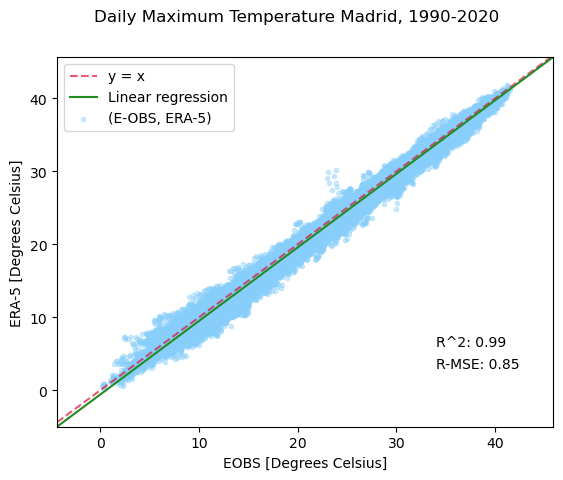

In [17]:
#  --  Madrid  --
fig, ax = plt.subplots(nrows = 1, ncols = 1)

ds_tx_madrid.plot.scatter(x = "tx_eobs", y = "tx_era5", ax = ax, marker = ".", alpha = 0.4, color = "lightskyblue", label = "(E-OBS, ERA-5)")
ax.axline(xy1=[0,0], xy2=[40,40], color = "crimson", alpha = 0.7, linestyle = "dashed", label = "y = x")

# add regression line:
x_vals = np.array(ax.get_xlim())  # axis limits
y_vals = model.intercept_ + model.coef_ * x_vals  # corresponding line
ax.axline(xy1=[x_vals[0], y_vals[0]], xy2=[x_vals[1], y_vals[1]], color = "forestgreen", label = "Linear regression")  # to get line to the edges of the plot

# alternative, simpler method, where line does not reach edges of the plot
#ax.plot(x_vals, y_vals, linestyle = "dashed", color = "gold", label = "Linear regression")  # plot regression line

ax.text(x=34, y=6, s = "R^2: {:.2f}".format(r_squared))
ax.text(x=34, y=3, s = "R-MSE: {:.2f}".format(r_mse))

ax.set_xlabel("EOBS [Degrees Celsius]")
ax.set_ylabel("ERA-5 [Degrees Celsius]")

plt.suptitle("Daily Maximum Temperature Madrid, 1990-2020")
plt.legend()

plt.show()
plt.savefig("data/statistics_era5_eobs_Madrid.png")
plt.close()

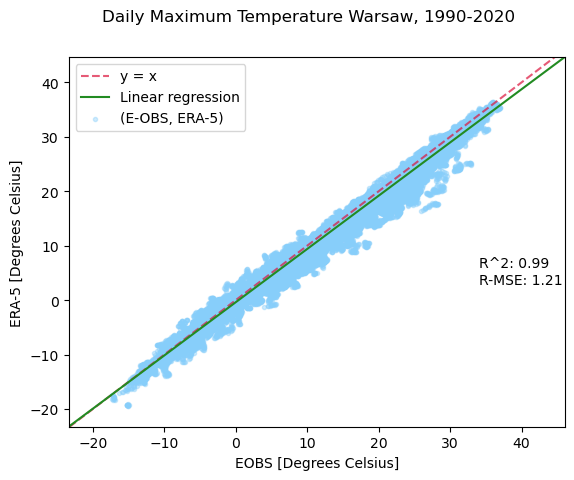

In [18]:
#  --  Warsaw  --
fig, ax = plt.subplots(nrows = 1, ncols = 1)

ds_tx_warsaw.plot.scatter(x = "tx_eobs", y = "tx_era5", ax = ax, marker = ".", alpha = 0.4, color = "lightskyblue",
                          label = "(E-OBS, ERA-5)")
ax.axline(xy1=[0,0], xy2=[40,40], color = "crimson", alpha = 0.7, linestyle = "dashed", label = "y = x")

# add regression line:
x_vals = np.array(ax.get_xlim())  # axis limits
y_vals = model_warsaw.intercept_ + model_warsaw.coef_ * x_vals  # use regression model to find y-values
ax.axline(xy1=[x_vals[0], y_vals[0]], xy2=[x_vals[1], y_vals[1]], color = "forestgreen", label = "Linear regression")  # to get line to the edges of the plot

# alternative, simpler method, where line does not reach edges of the plot
#ax.plot(x_vals, y_vals, linestyle = "dashed", color = "gold", label = "Linear regression")  # plot regression line

ax.text(x=34, y=6, s = "R^2: {:.2f}".format(r_squared_war))
ax.text(x=34, y=3, s = "R-MSE: {:.2f}".format(r_mse_war))

ax.set_xlabel("EOBS [Degrees Celsius]")
ax.set_ylabel("ERA-5 [Degrees Celsius]")

plt.suptitle("Daily Maximum Temperature Warsaw, 1990-2020")
plt.legend()

plt.show()
plt.savefig("data/statistics_era5_eobs_Warsaw.png")